## Part 4.2. Hybrid recommender embeddings

## The plan

- ### Data and model loading
- ### Useful classes and methods
- ### Some preparations...
- ### Bonus: light fm methods investigation
- ### Embeddings plot
  - #### T-SNE method
  - #### UMAP method

In [5]:
import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
import umap

import pickle

from recsys.config import opt
from recsys.dataset.column_categorizer import ColumnCategorizer
from recsys.models.lightfm import lfm_train_preprocessing, get_mappings, vis_lfm_embeddings

### Data and model loading

In [6]:
data_train_pos = pd.read_parquet(opt.path_to_data / "prepared-train-pos.parquet")
data_train_all = pd.read_parquet(opt.path_to_data / "prepared-train-all.parquet")
cold_items_data = pd.read_parquet(opt.path_to_data / "cold-items-data.parquet")

In [7]:
opt.model.name

'lfm_model.pkl'

In [8]:
with open(opt.path_to_models / opt.model.name, "rb") as fin:
    model = pickle.load(fin)

### Useful classes and methods

### Some preparations...

In [9]:
# Assign lists of features for training the lightfm dataset object
user_fe_cols = []
item_fe_cols = ["genre_ids", "artist_name", "composer", "language"]
user_id_column = opt.dataset.user_id_col
item_id_column = opt.dataset.item_id_col
target_column = opt.dataset.target_col
score_column = opt.dataset.score_col

#Other lists of features
cat_cols_to_change = ["genre_ids", "language"] #columns to add name to value
numeric_cols = [] #this columns will be categorized

#Columns in the result dataframe with targets and scores
result_cols = [user_id_column, item_id_column, target_column]

#####
#quantile list for categorization
QS = np.linspace(0, 1, 11, endpoint=True)
#####

#only a patch here (for the correct work of the interfaces)
categorizer = ColumnCategorizer(
    qs=QS, new_columns=numeric_cols, old_columns=numeric_cols,
)
categorizer.fit(data_train_all)

ColumnCategorizer(new_columns=[], old_columns=[],
                  qs=array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [10]:
%%time
prep_dict = lfm_train_preprocessing(
    data_train_pos,
    categorizer=categorizer,
    cat_cols_to_change=cat_cols_to_change,
    user_fe_cols=user_fe_cols,
    item_fe_cols=item_fe_cols,
    user_id_column=user_id_column,
    item_id_column=item_id_column,
    user_identity_features=True,
    item_identity_features=False
)
dataset = prep_dict["dataset"]
user_features = prep_dict["user_features"]
item_features = prep_dict["item_features"]

CPU times: user 14.9 s, sys: 476 ms, total: 15.4 s
Wall time: 15.9 s


In [11]:
mappings = get_mappings(dataset)

### Bonus: light fm methods investigation

In [12]:
scores_1 = model.predict(
    user_ids=np.array(range(10)),
    user_features=user_features[:10],
    item_ids=np.array(range(10)),
    item_features=item_features[:10],
    num_threads=4,
)
scores_1

array([-0.2216495,  2.7995965, -0.4122051, -1.2116625,  2.8777826,
        1.0175987, -2.3380573, -1.8941957,  3.9935176,  2.0163252],
      dtype=float32)

In [13]:
user_vecs = model.get_user_representations(user_features[:10])[1]
user_biases = model.get_user_representations(user_features[:10])[0]
item_vecs = model.get_item_representations(item_features[:10])[1]
item_biases = model.get_item_representations(item_features[:10])[0]
scores2 = np.sum(user_vecs * item_vecs, axis=1) + user_biases + item_biases
scores2

array([-0.22164941,  2.799596  , -0.4122057 , -1.2116648 ,  2.877784  ,
        1.0175984 , -2.3380587 , -1.8941967 ,  3.993517  ,  2.016325  ],
      dtype=float32)

#### So, we can get the same scores in two different ways. This example shows how predict() and get...representations() methods work. And with get...representations() method we'll get our item embeddings.


*** Another way to get the vectors and biases - use embeddings of categories (remember the model inference graph). Let's check it out:

In [14]:
len(mappings['item_fename_intid_mapping']) #the number of item categories in the model's vocab

64077

So, this is the source of the trained categories embeddings (!for all different item features categories in the vocab, for all item categorical features in the train data!, remember NLP:) 

In [15]:
model.item_embeddings.shape 

(64077, 198)

Use linear combination for vectors (let's compare to check:)

In [16]:
assert np.all(model.get_item_representations(item_features[:10])[1] == item_features[:10] @ model.item_embeddings)

And similarly for biases...

In [17]:
model.item_biases.shape

(64077,)

In [18]:
assert np.all(model.get_item_representations(item_features[:10])[0] == item_features[:10] @ model.item_biases)

This is the core of the model :)

### Embeddings plot

### Let's look at some songs vectors with their genre

In [19]:
######
SAMPLE_SIZE = 5000
######

#### T-SNE method

In [20]:
reducer = TSNE(2, random_state=opt.seed)

In [ ]:
vis_lfm_embeddings(
    data_train_pos, model, categorizer, reducer,
    item_fe_cols + [item_id_column],
    item_id_column, cat_cols_to_change, SAMPLE_SIZE,
    mappings, item_features, 8,
    (15, 15), 0.7, "genre_ids",
)

#### UMAP method

Let's try different metrics in the UMAP class

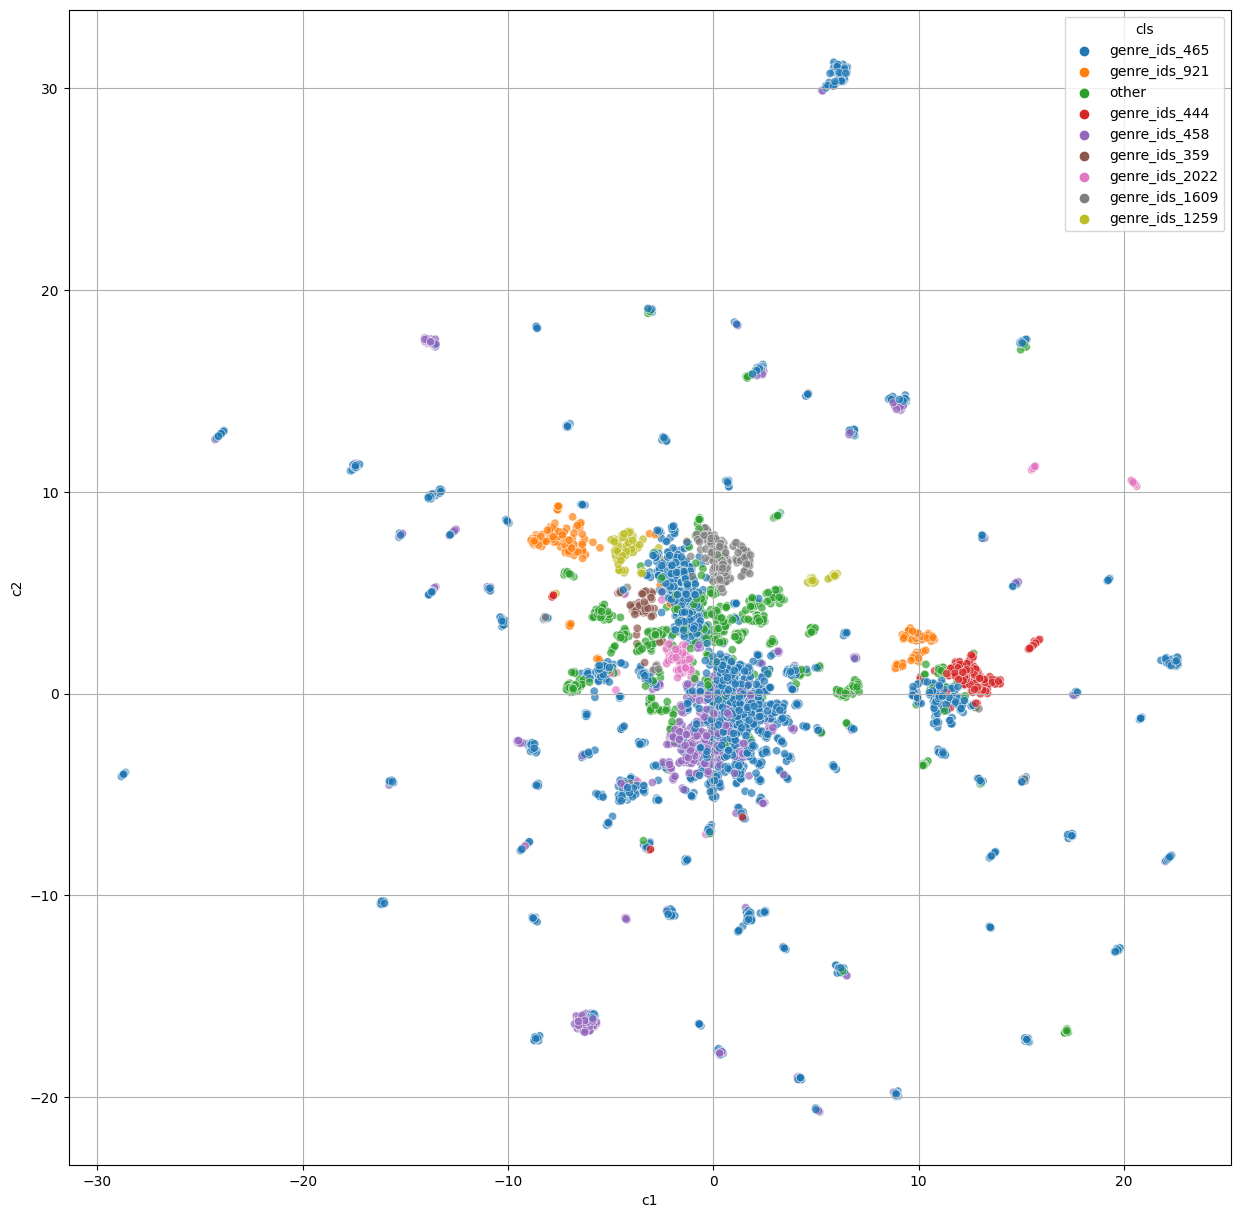

In [22]:
reducer = umap.UMAP(
    n_neighbors=20,
    min_dist=0.5,
    n_components=2,
    metric='euclidean',
    random_state=opt.seed
)

vis_lfm_embeddings(
    data_train_pos, model, categorizer, reducer,
    item_fe_cols + [item_id_column],
    item_id_column, cat_cols_to_change, SAMPLE_SIZE,
    mappings, item_features, 8,
    (15, 15), 0.7, "genre_ids"
)

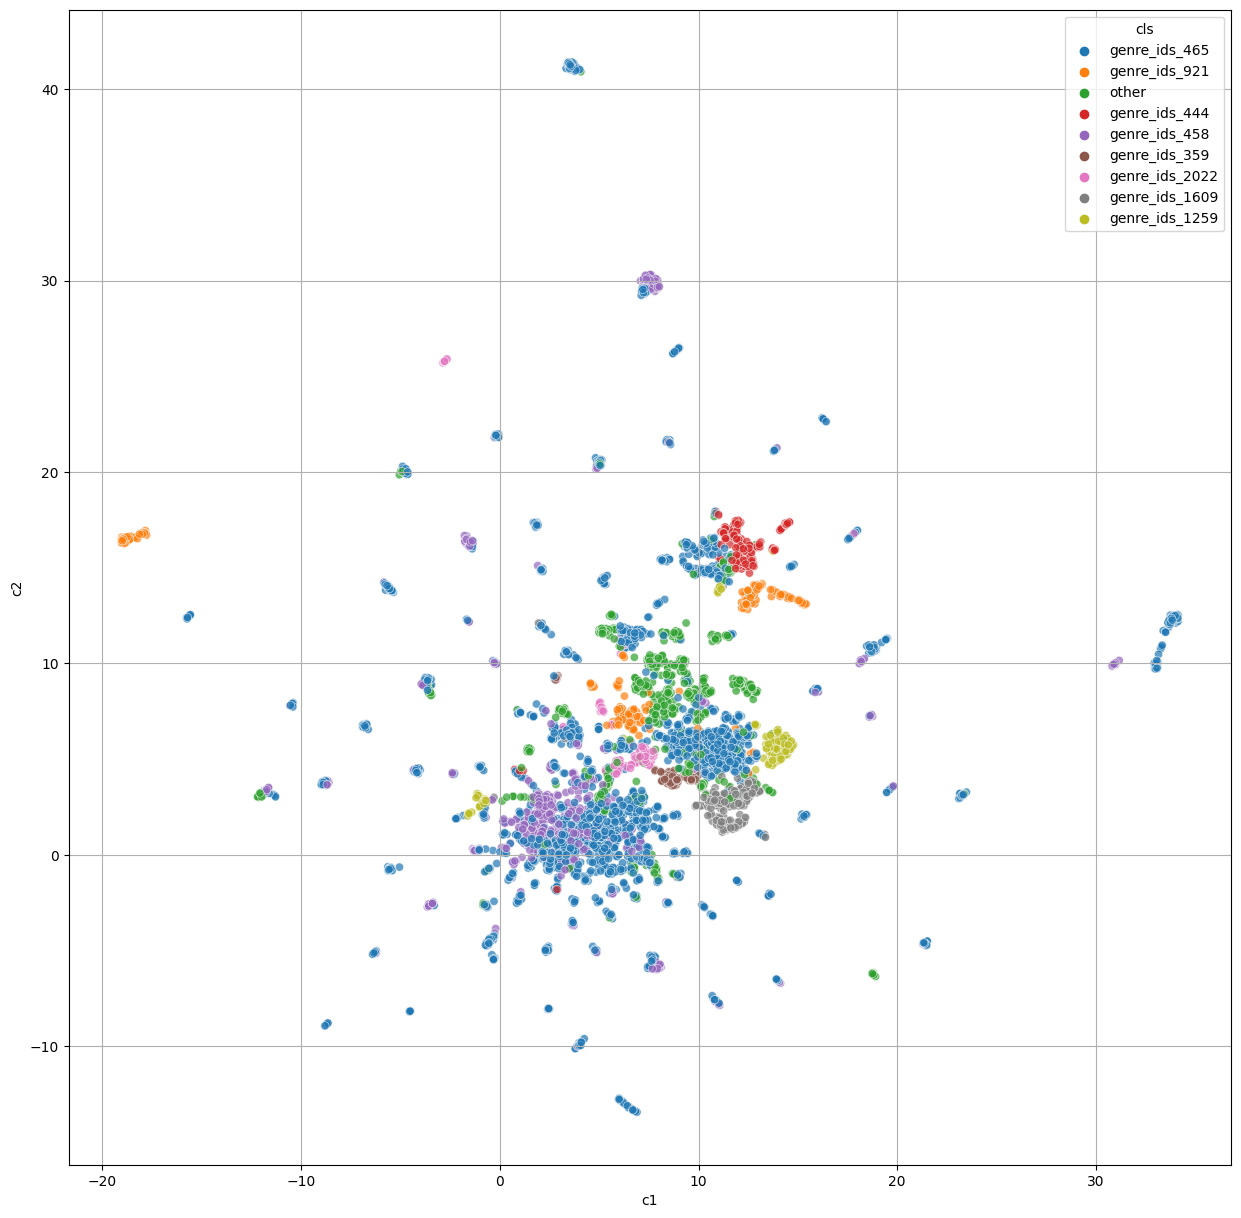

In [23]:
reducer = umap.UMAP(
    n_neighbors=20,
    min_dist=0.5,
    n_components=2,
    metric='cosine',
    random_state=opt.seed
)

vis_lfm_embeddings(
    data_train_pos, model, categorizer, reducer,
    item_fe_cols + [item_id_column],
    item_id_column, cat_cols_to_change, SAMPLE_SIZE,
    mappings, item_features, 8,
    (15, 15), 0.7, "genre_ids"
)

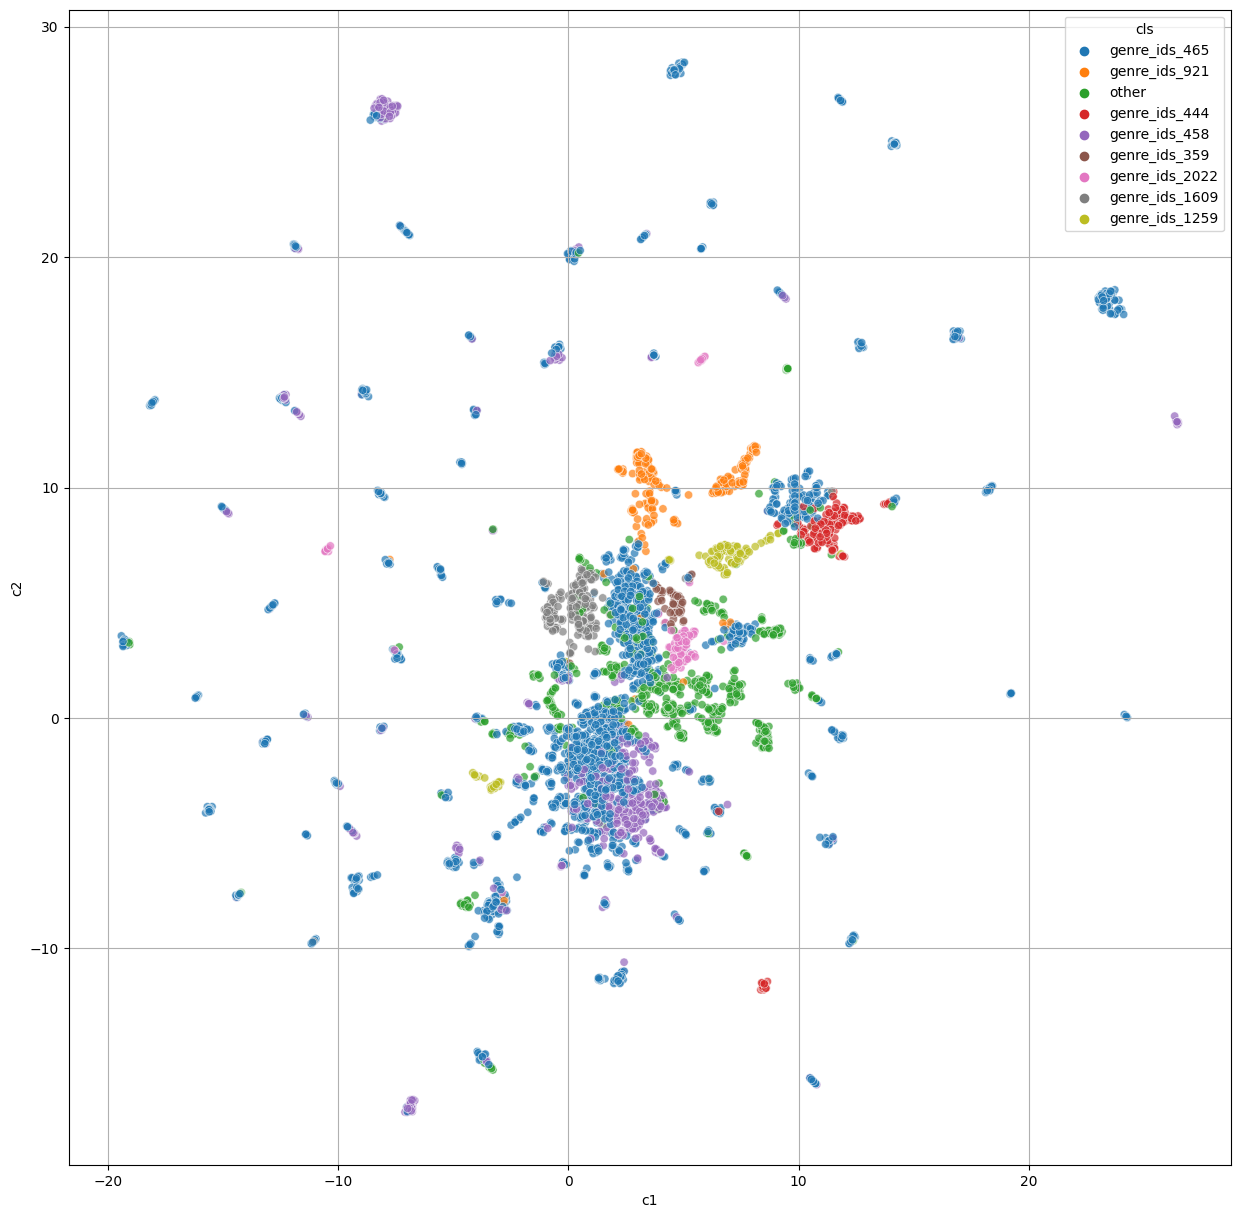

In [24]:
reducer = umap.UMAP(
    n_neighbors=20,
    min_dist=0.5,
    n_components=2,
    metric='manhattan',
    random_state=opt.seed
)

vis_lfm_embeddings(
    data_train_pos, model, categorizer, reducer,
    item_fe_cols + [item_id_column],
    item_id_column, cat_cols_to_change, SAMPLE_SIZE,
    mappings, item_features, 8,
    (15, 15), 0.7, "genre_ids",
)

### So, you can see that we have some clusters for hot and cold items.  At the same time, some genres are very similar.